# Lab 5: Modeling Acceptability with Language Models

**TODO 0**: Put your name and group members' name here.

In [4]:
%pip install nltk
import nltk
import numpy as np

Note: you may need to restart the kernel to use updated packages.


In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr4/ugrad/xfu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Step 0: Preamble
This notebook will guide you through implementing n-gram language models and an (untrained) RNN language model.

## Step 1: Load and preprocess the Penn Treebank corpus

In [6]:
nltk.download('treebank')
sents = list(nltk.corpus.treebank.sents())
print(sents[:10])

[nltk_data] Downloading package treebank to
[nltk_data]     /usr4/ugrad/xfu/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


[['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'], ['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'], ['Rudolph', 'Agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'Consolidated', 'Gold', 'Fields', 'PLC', ',', 'was', 'named', '*-1', 'a', 'nonexecutive', 'director', 'of', 'this', 'British', 'industrial', 'conglomerate', '.'], ['A', 'form', 'of', 'asbestos', 'once', 'used', '*', '*', 'to', 'make', 'Kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', '*', 'to', 'it', 'more', 'than', '30', 'years', 'ago', ',', 'researchers', 'reported', '0', '*T*-1', '.'], ['The', 'asbestos', 'fiber', ',', 'crocidolite', ',', 'is', 'unusually', 'resilient', 'once', 'it', 'enters', 'the', 'lungs', ',', 'with', 'even', 'brief', 'exposure

You will see that the corpus is already split into tokens.

**TODO 1**: Your first task is to create a flattened corpus with \<start\> and \<end\> tokens to each sentence. Write the function **preprocess(corpus, n)** that achieves this goal. The function should add $n-1$ occurrences of \<start\> and \<end\>---for example, if you are going to get bigram statistics ($n=2$), it should append one of each, and for trigram counts, it should append two of each. It should return a list of words (i.e., "flattened"), not a list of sentences like `sents` does. Check that the first 100 words in the preprocessed corpus looks like the following for trigram preprocessing:
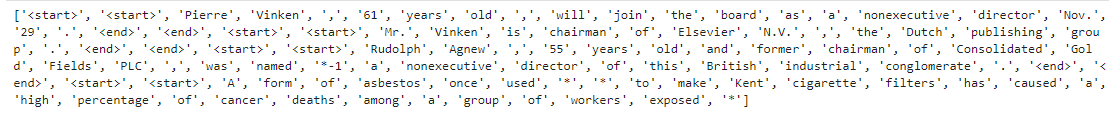

In [9]:
def preprocess(corpus, n):
    preprocessed_corpus = []
    start_token = '<start>'
    end_token = '<end>'
    # Loop through each sentence in the corpus
    for sentence in corpus:
        sentence = [start_token] * (n - 1) + sentence + [end_token] * (n - 1)
        preprocessed_corpus.extend(sentence)
    return preprocessed_corpus

# If you correctly implemented the preprocess function,
# the following lines should print something that looks like the screenshot above
preprocessed_corpus = preprocess(sents, 3)
print(preprocessed_corpus[:100])

['<start>', '<start>', 'Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.', '<end>', '<end>', '<start>', '<start>', 'Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.', '<end>', '<end>', '<start>', '<start>', 'Rudolph', 'Agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'Consolidated', 'Gold', 'Fields', 'PLC', ',', 'was', 'named', '*-1', 'a', 'nonexecutive', 'director', 'of', 'this', 'British', 'industrial', 'conglomerate', '.', '<end>', '<end>', '<start>', '<start>', 'A', 'form', 'of', 'asbestos', 'once', 'used', '*', '*', 'to', 'make', 'Kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', '*']


## Step 2: Build an n-gram language model

The following is the equation for computing the probability of a sequence of $n$ tokens under the Markov assumption where the conditional probabilities are simplified to take into account only $k$ previous tokens. A language model that makes this simplifying assumption is called a $k+1$-gram model.

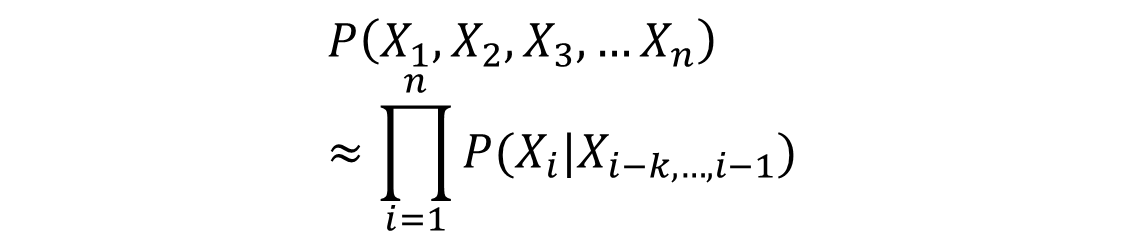

I've written the function **count_ngrams(n, corpus)** that returns a dictionary that consists of n-gram sequence:count pairs given $n$ and the preprocessed corpus.

**TODO 2.1**: Write the function **ngram_logprob(...)** that returns the n-gram **log** probability of a sentence, given the sentence in string format and two counter dictionaries (for n-gram and n-1-gram). You might find the `nltk.ngrams()` method useful. Use Laplace (add-1) smoothing.

In [20]:
def create_ngram_counter(n, corpus):
    fd = nltk.FreqDist(nltk.ngrams(corpus, n))
    return {ngram: count for ngram, count in fd.items()}

def ngram_logprob(sentence, n, ngram_counts, ngram_minus_one_counts):
    tokens = nltk.word_tokenize(sentence)
    tokens = ['<start>'] * (n-1) + tokens + ['<end>'] * (n-1)
    
    ngrams = list(nltk.ngrams(tokens, n))
    
    log_prob = 0
    
    for ngram in ngrams:
        ngram_count = ngram_counts.get(ngram, 0)
        ngram_minus_one = ngram[:-1]
        ngram_minus_one_count = ngram_minus_one_counts.get(ngram_minus_one, 0)
        
        log_prob += math.log((ngram_count + 1) / (ngram_minus_one_count + v))
    
    return log_prob

In [21]:
trigram_counter = create_ngram_counter(3, preprocessed_corpus)
bigram_counter = create_ngram_counter(2, preprocessed_corpus)
unigram_counter = create_ngram_counter(1, preprocessed_corpus)
v = len(unigram_counter)
print(v)

12410


**TODO 2.2**: Show that a grammatical sentence `cigarette filters has caused a high percentage of cancer deaths` has higher log probability than an ungrammatical sentence `high filters cancer has cigarette caused deaths a of percentage` (that consists of the same words as the grammatical one), using a **trigram** model.

In [22]:
# Put two print statements that print the logprobs of the two sentences here

grammatical_sentence = "cigarette filters has caused a high percentage of cancer deaths"
ungrammatical_sentence = "high filters cancer has cigarette caused deaths a of percentage"

grammatical_logprob = ngram_logprob(grammatical_sentence, 3, trigram_counter, bigram_counter)
ungrammatical_logprob = ngram_logprob(ungrammatical_sentence, 3, trigram_counter, bigram_counter)

print(f"Log probability of grammatical sentence: {grammatical_logprob}")
print(f"Log probability of ungrammatical sentence: {ungrammatical_logprob}")

Log probability of grammatical sentence: -107.8458234359352
Log probability of ungrammatical sentence: -113.38922835671089


Lau et al. found that the normalized log probability by division (Norm LP (Div)) correlates well with human acceptability judgments. 
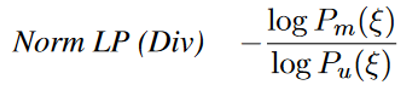

**TODO 3.1**: Implement the Norm LP (Div) measure. $\xi$ denotes the input sequence, $\log P_m$ denotes the n-gram logprob, and $\log P_u$ denotes the unigram logprob.

In [23]:
def norm_lp_div(sentence, n, ngram_counts, ngram_minus_one_counts, unigram_counts):
    tokens = nltk.word_tokenize(sentence)
    sentence_length = len(tokens)
    
    log_pm = ngram_logprob(sentence, n, ngram_counts, ngram_minus_one_counts)
    log_pu = ngram_logprob(sentence, 1, unigram_counts, {(): sum(unigram_counts.values())})
    
    return (log_pm - log_pu) / sentence_length

**TODO 3.2**: Show that a grammatical sentence `He likes cats and dogs` has higher Norm LP (Div) measure than an ungrammatical sentence `likes dogs he cats and`, using a trigram model.

In [24]:
# Put two print statements that print the Norm LP (Div) measures for the two sentences here

# Preprocess the corpus
preprocessed_corpus = preprocess(sents, 3)

# Create trigram, bigram, and unigram count dictionaries
trigram_counts = create_ngram_counter(3, preprocessed_corpus)
bigram_counts = create_ngram_counter(2, preprocessed_corpus)
unigram_counts = create_ngram_counter(1, preprocessed_corpus)

# Define the grammatical and ungrammatical sentences
grammatical_sentence = "He likes cats and dogs"
ungrammatical_sentence = "likes dogs he cats and"

# Calculate and print the Norm LP (Div) measures for the sentences
grammatical_norm_lp_div = norm_lp_div(grammatical_sentence, 3, trigram_counts, bigram_counts, unigram_counts)
ungrammatical_norm_lp_div = norm_lp_div(ungrammatical_sentence, 3, trigram_counts, bigram_counts, unigram_counts)

print(f"Norm LP (Div) measure of the grammatical sentence: {grammatical_norm_lp_div}")
print(f"Norm LP (Div) measure of the ungrammatical sentence: {ungrammatical_norm_lp_div}")

Norm LP (Div) measure of the grammatical sentence: -2.9624827205110877
Norm LP (Div) measure of the ungrammatical sentence: -4.038743365922642


## Step 3: Building an RNN language model

This part requires more bells and whistles than the n-gram language model, so we'll be leaving a large portion of the RNNLM as a part of the next assignment. During lab, we'll define the Simple Recurrent Network (SRN) model architecture from Elman (1990), and implement the forward pass.

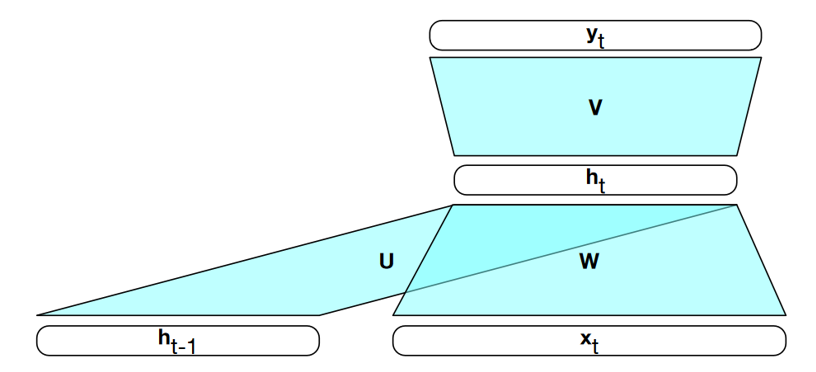

In [25]:
vocabulary = {word[0]:i for i, word in enumerate(unigram_counter.keys())}
print(len(vocabulary))

12410


**TODO 4**: I've written most of the SRN model code already. Your job here is to complete the forward pass computation by adding code that computes `h` at for each input (i.e., for each timestep). Use `np.tanh()` as the activation function for the hidden layer, and use `softmax` for the output layer.

FYI: `@` is the matrix multiplication operator.

In [36]:
def softmax(x):
    return (np.exp(x)/np.exp(x).sum())

def inputs_embed(inputs, vocabulary):
    embedded_inputs = []
    unk_idx = len(vocabulary)
    for inp in inputs:
        vec = np.zeros((len(vocabulary)+1, 1))
        one_hot_idx = vocabulary.get(inp, unk_idx)
        vec[one_hot_idx] = 1
        embedded_inputs.append(vec)
    return np.array(embedded_inputs).squeeze()

class SRN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.sigma = 1
        self.mu = 0
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.W = self.sigma * np.random.randn(hidden_dim, input_dim) + self.mu
        self.U = self.sigma * np.random.randn(hidden_dim, hidden_dim) + self.mu
        self.V = self.sigma * np.random.randn(output_dim, hidden_dim) + self.mu

        self.b_h = np.zeros((hidden_dim, 1))

        # Update the shape of b_out since I got an error in the shapes of the matrices being multiplied in the softmax function
        self.b_out = np.zeros((output_dim, 1))  

    def forward(self, inputs):
        h = self.sigma * np.random.randn(self.hidden_dim) + self.mu
        for i in inputs:
            i = np.expand_dims(i, axis=1)
            # TODO: write code that compute the hidden state at each timestep.
            # Use np.tanh() as the activation function
            h = np.tanh(self.W @ i + self.U @ h + self.b_h)
        output = softmax(self.V @ h + self.b_out) # TODO: write code that computes the final output
        return output

Running the code cell below will give you something like:

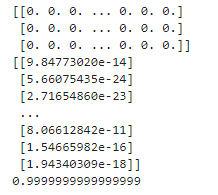

(But this is not very informative because this model isn't trained on any data. We will hopefully have time to get to this in later classes)

In [40]:
np.random.seed(100)

model = SRN(len(vocabulary)+1, 100, len(vocabulary)+1)
inputs = inputs_embed("my name is".split(), vocabulary)
print(inputs)
out = model.forward(inputs)
print(out)
print(np.sum(out))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[2.47469089e-21 1.87642481e-21 1.66345461e-22 ... 5.78178148e-18
  1.87642481e-21 1.12694148e-19]
 [3.37409480e-18 9.37802897e-19 2.11069831e-15 ... 1.23227884e-17
  9.37802897e-19 4.51882528e-19]
 [1.67026884e-19 6.89108197e-20 1.30785138e-20 ... 2.06904381e-21
  6.89108197e-20 1.86360999e-25]
 ...
 [2.30862766e-16 7.84565493e-17 1.98147068e-17 ... 3.66294227e-14
  7.84565493e-17 3.31319545e-21]
 [1.75920727e-25 2.24910939e-25 9.50616544e-11 ... 3.45159987e-25
  2.24910939e-25 4.51372958e-23]
 [3.18533035e-13 1.34368585e-12 3.36785335e-28 ... 2.64906129e-13
  1.34368585e-12 3.80648404e-18]]
1.0000000000000002
